In [1]:
!pip install opencv-python

In [2]:
!pip install --upgrade pip

In [3]:
!pip install matplotlib

In [4]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
print(cv2.__version__)

4.10.0


In [5]:
import sys
import os

# Get the absolute path of the src directory
src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.append(src_path)

In [6]:
import importlib
import process_image
importlib.reload(process_image)

from process_image import resize_raw_image, create_all_subimages
from process_image import get_bounding_boxes, set_up_training_file, show_images_with_bbox

## pre-process the image so only retained the interested portion of the image

In [7]:
# image1
# Input details
input_dir = "../Barnacles"
processed_dir = "../processed_images"

resize_width = 1536

In [8]:
image_file = "img1.png"
mask_file = "mask1.png"

top_left = [1140, 508]
top_right = [2542, 466]
bottom_right = [2540, 1930]
bottom_left = [1132, 1897]

resize_raw_image(input_dir, image_file, top_left, top_right, bottom_left, bottom_right, processed_dir, resize_width)
resize_raw_image(input_dir, mask_file, top_left, top_right, bottom_left, bottom_right, processed_dir, resize_width)

Image warped and resized successfully. Saved as ../processed_images/resized_img1.png.
Image warped and resized successfully. Saved as ../processed_images/resized_mask1.png.


In [9]:
image_file = "img2.png"
mask_file = "mask2.png"

top_left = [951, 229]
top_right = [2586, 228]
bottom_right = [2549, 1854]
bottom_left = [957, 1860]

resize_raw_image(input_dir, image_file, top_left, top_right, bottom_left, bottom_right, processed_dir, resize_width)
resize_raw_image(input_dir, mask_file, top_left, top_right, bottom_left, bottom_right, processed_dir, resize_width)

Image warped and resized successfully. Saved as ../processed_images/resized_img2.png.
Image warped and resized successfully. Saved as ../processed_images/resized_mask2.png.


## generate all subimages, and also an index file of image/mask file name

In [13]:
sub_image_df = create_all_subimages(source_dir=processed_dir, target_dir=f'{processed_dir}/sub_images', 
                     img_file='resized_img1', mask_file='resized_mask1', grid_size=512,
                     num_samples=250)

In [14]:
sub_image_df.to_csv(f'{processed_dir}/sub_images_index/index1.csv', index=False)

In [15]:
sub_image_df2 = create_all_subimages(source_dir=processed_dir, target_dir=f'{processed_dir}/sub_images', 
                     img_file='resized_img2', mask_file='resized_mask2', grid_size=512,
                     num_samples=250)

In [16]:
sub_image_df2.to_csv(f'{processed_dir}/sub_images_index/index2.csv', index=False)

## generate bounding boxes for each subimage

In [17]:
# Load the image to test
image_path = '../processed_images/sub_images/resized_mask1_00001.jpg'  # Replace with your image path

bboxes = get_bounding_boxes(image_path=image_path, is_show=False)

In [18]:
index1 = pd.read_csv("../processed_images/sub_images_index/index1.csv")
index2 = pd.read_csv("../processed_images/sub_images_index/index2.csv")

all_sub_images = pd.concat([index1, index2]).reset_index(drop=True)

In [19]:
all_sub_images

,image,image_mask
0,resized_img1_00001.jpg,resized_mask1_00001.jpg
1,resized_img1_00002.jpg,resized_mask1_00002.jpg
2,resized_img1_00003.jpg,resized_mask1_00003.jpg
3,resized_img1_00004.jpg,resized_mask1_00004.jpg
4,resized_img1_00005.jpg,resized_mask1_00005.jpg
...,...,...
3995,resized_img2_01996.jpg,resized_mask2_01996.jpg
3996,resized_img2_01997.jpg,resized_mask2_01997.jpg
3997,resized_img2_01998.jpg,resized_mask2_01998.jpg
3998,resized_img2_01999.jpg,resized_mask2_01999.jpg


In [20]:
bboxes_list = []
width_list = []
height_list = []
for index, row in all_sub_images.iterrows():
    image, mask = row['image'], row['image_mask']
    width, height, bboxes = get_bounding_boxes(image_path=f'{processed_dir}/sub_images/{mask}')
    width_list.append(width)
    height_list.append(height)
    bboxes_list.append(bboxes)

In [21]:
all_sub_images = all_sub_images.assign(image_width=width_list, image_height=height_list, bboxes = bboxes_list)

## generate training data files for YOLO

In [22]:
from sklearn.model_selection import train_test_split
random_seed = 42

In [23]:
def format_df_for_yolo_training(df, train_pct=0.6, validation_pct=0.2, test_pct=0.2):
    """
    reformat dataframe to have the right columns for YOLO training, it should have x_center, y_center, width, height
    """
    df_new = df.explode("bboxes")
    df_new[["x", "y", "w", "h"]] = pd.DataFrame(df_new["bboxes"].tolist(), index=df_new.index)

    # Drop the original 'bboxes' column if no longer needed
    df_new = df_new.drop(columns=["bboxes"])

    df_new['x_center'] = df_new['x']+df_new['w']/2
    df_new['y_center'] = df_new['y']+df_new['h']/2
    df_new['classes'] = 0

    # split into train, validation, and test
    unique_image_ids = df_new['image'].unique()
    train_val_ids, test_ids = train_test_split(unique_image_ids, test_size=test_pct/(train_pct+validation_pct+test_pct), random_state=random_seed)
    train_ids, val_ids = train_test_split(train_val_ids, test_size=validation_pct/(train_pct+validation_pct), random_state=random_seed)

    df_new['split'] = np.where(df_new['image'].isin(train_ids), 'train', 
        np.where(df_new['image'].isin(val_ids), 'valid', 'test')
    )
    return df_new

In [24]:
train_pct, validation_pct, test_pct = 0.7, 0.2, 0.1
df_yolo = format_df_for_yolo_training(all_sub_images, train_pct=train_pct, validation_pct=validation_pct, test_pct=test_pct)

In [25]:
df_yolo

,image,image_mask,image_width,image_height,x,y,w,h,x_center,y_center,classes,split
0,resized_img1_00001.jpg,resized_mask1_00001.jpg,512,512,291,500,31,12,306.5,506.0,0,train
0,resized_img1_00001.jpg,resized_mask1_00001.jpg,512,512,79,498,26,14,92.0,505.0,0,train
0,resized_img1_00001.jpg,resized_mask1_00001.jpg,512,512,174,496,40,16,194.0,504.0,0,train
0,resized_img1_00001.jpg,resized_mask1_00001.jpg,512,512,224,484,35,28,241.5,498.0,0,train
0,resized_img1_00001.jpg,resized_mask1_00001.jpg,512,512,320,481,21,19,330.5,490.5,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...
3999,resized_img2_02000.jpg,resized_mask2_02000.jpg,512,512,489,17,23,41,500.5,37.5,0,train
3999,resized_img2_02000.jpg,resized_mask2_02000.jpg,512,512,60,3,43,34,81.5,20.0,0,train
3999,resized_img2_02000.jpg,resized_mask2_02000.jpg,512,512,348,0,45,16,370.5,8.0,0,train
3999,resized_img2_02000.jpg,resized_mask2_02000.jpg,512,512,207,0,43,18,228.5,9.0,0,train


In [26]:
df_result = set_up_training_file(data_dir='../yolo_dali_data', df=df_yolo, source_data_dir='../processed_images/sub_images')

100%|██████████| 4000/4000 [00:04<00:00, 882.48it/s] 


In [28]:
yolo_data_dr = '/Users/samueljin/IdeaProjects/LLMs-from-scratch/DALI_Lab/yolo_dali_data'
yaml_text = f"""path: {yolo_data_dr}
train: images/train/
val: images/valid/

nc: 1
names: ['bncl']"""
with open(f"{yolo_data_dr}/barnacle.yaml", 'w') as f:
    f.write(yaml_text)

## verify bounding box file processing logic

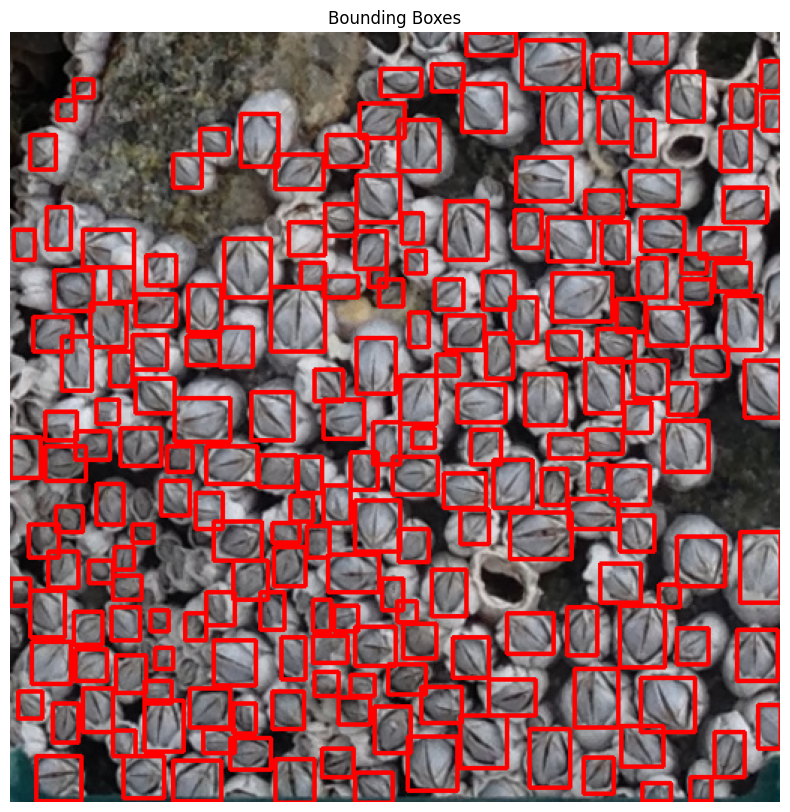

In [29]:
# Load the image
image_path = f'{yolo_data_dr}/images/valid/resized_img1_00014.jpg'  # Replace with the path to your image file
bbox_file = f'{yolo_data_dr}/labels/valid/resized_img1_00014.txt'  # Replace with the path to your bounding box file

show_images_with_bbox(image_path=image_path, bbox_file=bbox_file)

In [ ]:
#The labeled bounding boxes we use for training data seem accurate

In [ ]:
#Now, we move on to training our deep-learning detection model, using generated data.